In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import sys
import os

import torch
import torchsde
from functorch import vmap
from torchdiffeq import odeint
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
import dem
from dem.models.components.mlp import MyMLP


from dem.energies.gmm_energy import GMM

/network/scratch/b/bosejoey/micromamba/envs/dem/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)


cuda


In [4]:

from dem.models.components.sde_integration import integrate_ode
from dem.models.components.clipper import Clipper
from dem.models.components.noise_schedules import LinearNoiseSchedule
from dem.energies.base_prior import Prior
# noise_schedule = GeometricNoiseSchedule(sigma_min=0.000004, sigma_max=0.4)
beta = torch.tensor(0.2).to(device)
noise_schedule = LinearNoiseSchedule(beta)
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=50
)

prior = Prior(dim=2, device=device, scale = noise_schedule.h(1) ** 0.5)

In [5]:
import torch
from torch.autograd.functional import jacobian
import abc

class ReverseODE(torch.nn.Module):
    def __init__(self, drift, noise_schedule):
        super().__init__()
        self.drift = drift
        self.noise_schedule = noise_schedule
    
    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)

            return self.drift(t, x)
# Can you fix the indentation of the code? 
class Schedule_base(metaclass=abc.ABCMeta):
    """Abstract base class from which all log densities should inherit."""

    def __init__(self):
        pass

    def __call__(self, x):
        outf = self.tt(x)
        doutf = self.dtt(x)
        
        return outf, doutf

    @abc.abstractmethod
    def tt(self, x): 
        pass

    @abc.abstractmethod
    def dtt(self, x): 
        pass

class CosSchedule(Schedule_base):
    def __init__(self):
        super().__init__()
    def tt(self,t):
        out = 0.5*(1.0-torch.cos(torch.pi*t))
        return out

    def dtt(self,t):
        out = (0.5*torch.pi*torch.sin(torch.pi*t))
        return out

class LinearSchedule(Schedule_base):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def tt(self, t):
        out = t 
        return out

    def dtt(self, t):
        out = torch.tensor(1.0).to(self.device)
        return out

In [6]:

def comput_SandRHS(x, t, schedule, target, prior):
    outf, doutf = schedule(t)

    x.requires_grad_(True)
    logtarget = target(x)
    dlogtarget = torch.vmap(torch.func.grad(lambda x: target(x)))(x)
    logprior = prior.log_prob(x)
    dlogprior, = torch.autograd.grad(logprior.sum(), x, create_graph=True)
    
    Score = outf * dlogtarget + (1-outf) * dlogprior
    RHS = - (doutf * logtarget  - doutf * logprior)

    return Score, RHS

def comput_RHSmean(x, w, t, schedule, target, prior):
    outf, doutf = schedule(t)
    logtarget = target(x)
    logprior = prior.log_prob(x)
    RHS = - (doutf * logtarget  - doutf * logprior)

    RHSmean = (RHS.flatten()*torch.exp(w)/torch.exp(w).mean()).mean()
    return RHSmean

def comput_eqloss(x, t, vectorfield, schedule, target, prior, RHSmean = None):
    Score, RHS = comput_SandRHS(x, t, schedule, target, prior)
    t_in = t.repeat(x.shape[0], 1)
    vel = vectorfield(t_in, x)
    div = compute_divergence(t_in, x, vectorfield)

    if RHSmean == None:
        RHSmean = RHS.mean()
        
    LHS = div + (Score*vel).sum(axis=1)
    
    eqloss =  (LHS - (RHS.flatten()-RHSmean))

    eqloss = torch.nan_to_num(eqloss, posinf=1.0, neginf = -1.0)
    eqloss = eqloss.pow(2).mean()
    
    return eqloss, (eqloss/torch.nan_to_num(RHS).var()).detach()

def compute_divergence(t, x, vectorfield):
    jac = torch.func.jacrev(vectorfield, argnums=1)(t, x)
    div = torch.diagonal(jac, dim1=-2, dim2=-1).sum(dim=(-1,-2))
    return div

In [7]:
def generate_samples(reverse_ode, num_samples, end_time, return_full_trajectory, prior, target, clipper, schedule, compute_weight=False):
    samples = prior.sample(num_samples)
    
    return integrate_ode(
        reverse_ode,
        samples,    
        dt=1.0 / 512,
        end_time=end_time,
        energy_function=target,
        prior=prior,
        clipper=clipper,
        schedule=schedule,  
        reverse_time = False,
        compute_weight=compute_weight
    )

Buffer not initialised, expected that checkpoint will be loaded.


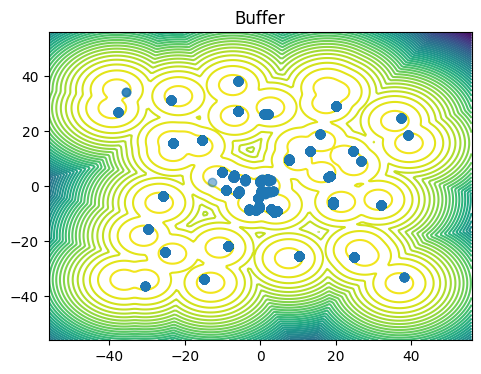

In [8]:
from dem.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    2,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)
target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)
x1_samples = prior.sample(1000).to(device)
x1_energy = target(x1_samples)
buffer.add(x1_samples, x1_energy)

def ground_truth_score(t, x):
    outf, doutf = schedule(t)
    x.requires_grad_(True)
    dlogtarget = torch.vmap(torch.func.grad(lambda x: target(x)))(x)
    logprior = prior.log_prob(x)
    dlogprior, = torch.autograd.grad(logprior.sum(), x, create_graph=True)
    score = outf[:, None] * dlogtarget + (1-outf[:, None]) * dlogprior
    score = clipper.clip_scores(score)
    return score

clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=50
)
schedule = CosSchedule()
ground_truth_reverse_ode = ReverseODE(ground_truth_score, noise_schedule)
t_init,t_end = torch.tensor(0.0).to(device), torch.tensor(1.0).to(device)
samples, weights = generate_samples(ground_truth_reverse_ode, 10_000, end_time=t_end, return_full_trajectory=False, prior=prior,
                                    target=target, clipper=clipper, schedule=schedule, compute_weight=False)
samples_energy = target(samples[-1])
target.get_dataset_fig(target.unnormalize(samples[-1]))
plt.show()


In [9]:
outer_epochs= 100
inner_epochs = 4

batch_size = 512
train_dataset = TensorDataset(x1_samples.clone(), x1_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

In [10]:
def divergence(t, x, vectorfield):
    # compute the divergence of the flow field
    def _func_sum(t_in, x_in):
        return vectorfield(t_in, x_in).sum(dim=0) # sum over the batches
    out=jacobian(_func_sum, (t, x),create_graph =True,vectorize=True)
    spatial_grad = out[1]
    div = spatial_grad.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)
    return div


def compute_pf_loss(x, t, schedule, target, prior, vectorfield):    
    outf, doutf = schedule(t)
    x.requires_grad_(True)
    logtarget = target(x)
    dlogtarget = torch.vmap(torch.func.grad(lambda x: target(x)))(x)
    logprior = prior.log_prob(x)
    dlogprior = torch.autograd.grad(logprior.sum(), x, create_graph=True)[0]
    score = outf * dlogtarget + (1-outf) * dlogprior
    score = clipper.clip_scores(score)  

    t_repeat = t.repeat(x.shape[0], 1)
    vel = vectorfield(t_repeat, x)
    div = divergence(t_repeat, x, vectorfield)
    inner_prod = (score*vel).sum(axis=1)

    term1 = (inner_prod - div).pow(2)
    partial_Ht = - (doutf * logtarget  - doutf * logprior)
    nabla_partial_Ht = torch.autograd.grad(partial_Ht.sum(), x, create_graph=True)[0]
    
    term2 = 2* (nabla_partial_Ht.squeeze() * vel).sum(axis=1)

    #loss = (term1 + term2).pow(2)
    loss = (term1 + term2)

    return loss

In [11]:
vectorfield = MyMLP().to(device)
optimizer = Adam(vectorfield.parameters(), lr=1e-3)
weighted = False

In [ ]:
epsilon = 1e-6
reverse_ode = ReverseODE(vectorfield, noise_schedule)
dt = 1.0/ 512
num_samples = 1_024

for epoch in tqdm(range(outer_epochs)):
    target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)
    t = t_init
    x_gen, weights = generate_samples(reverse_ode, num_samples, end_time=t_end, return_full_trajectory=False,
                                           prior=prior, target=target, clipper=clipper, schedule=schedule,
                                            compute_weight=False)
    while t < t_end - epsilon:
        total_loss = 0.
        x_gen, weights = generate_samples(reverse_ode, num_samples, end_time=t, return_full_trajectory=False,
                                           prior=prior, target=target, clipper=clipper, schedule=schedule,
                                            compute_weight=False)
        x_gen = x_gen[-1].detach()
        for i in range(inner_epochs):
            optimizer.zero_grad()
            if i % 2 == 0:
                x_gen, weights = generate_samples(reverse_ode, num_samples, end_time=t, return_full_trajectory=False,
                                                prior=prior, target=target, clipper=clipper, schedule=schedule,
                                                compute_weight=False)
                x_gen = x_gen[-1].detach()

            loss = compute_pf_loss(x_gen, t, schedule, target, prior, vectorfield)
            loss = loss.mean()
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            if i % 24 == 0:
                print("Epoch %d | Inner Epoch %d | Time %f | Loss %f" % (epoch, i, t.item(), loss.item()))

        t = t+dt

    # Generate samples using the network

    samples, weights = generate_samples(reverse_ode, 1000, end_time=t, return_full_trajectory=False, prior=prior, 
                               target=target, clipper=clipper, schedule=schedule, compute_weight=False)
    samples = samples[-1]
    
    samples_energy = target(samples)

    # Update Buffer 
    buffer.add(samples, samples_energy)

    target.get_dataset_fig(target.unnormalize(samples))
    plt.show()

    # # Resample data from the buffer
    # samples, samples_energy, _ = buffer.sample(512 * 10)
    # train_dataset = TensorDataset(samples, samples_energy)
    # trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Inner Epoch 0 | Time 0.000000 | Loss 0.735618
Epoch 0 | Inner Epoch 0 | Time 0.001953 | Loss 0.365703
Epoch 0 | Inner Epoch 0 | Time 0.003906 | Loss 0.102210
Epoch 0 | Inner Epoch 0 | Time 0.005859 | Loss -0.204144
Epoch 0 | Inner Epoch 0 | Time 0.007812 | Loss -0.462976
Epoch 0 | Inner Epoch 0 | Time 0.009766 | Loss -0.605170
Epoch 0 | Inner Epoch 0 | Time 0.011719 | Loss -1.049009
Epoch 0 | Inner Epoch 0 | Time 0.013672 | Loss -1.622679
Epoch 0 | Inner Epoch 0 | Time 0.015625 | Loss -3.355284
Epoch 0 | Inner Epoch 0 | Time 0.017578 | Loss -3.112798
Epoch 0 | Inner Epoch 0 | Time 0.019531 | Loss -5.453327
Epoch 0 | Inner Epoch 0 | Time 0.021484 | Loss -9.842646
Epoch 0 | Inner Epoch 0 | Time 0.023438 | Loss -14.737366
Epoch 0 | Inner Epoch 0 | Time 0.025391 | Loss -14.664791
Epoch 0 | Inner Epoch 0 | Time 0.027344 | Loss -32.511951
Epoch 0 | Inner Epoch 0 | Time 0.029297 | Loss -47.064861
Epoch 0 | Inner Epoch 0 | Time 0.031250 | Loss -63.345802
Epoch 0 | Inner Epoch 0 | Tim

In [ ]:
target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)
reverse_ode = ReverseODE(vectorfield, noise_schedule)
samples, weights = generate_samples(reverse_ode, 2_000, end_time=t_end, return_full_trajectory=False,
                           prior=prior, target=target, clipper=clipper, schedule=schedule, compute_weight=True)

samples_energy = target(samples[-1])
target.get_dataset_fig(target.unnormalize(samples[-1]))
plt.show()

In [ ]:
target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)
reverse_ode = ReverseODE(vectorfield, noise_schedule)
samples = generate_samples(reverse_ode, 1000, end_time=t_end, return_full_trajectory=False)[-1]
samples_energy = target(samples)
target.get_dataset_fig(target.unnormalize(samples))
plt.show()

In [ ]:
target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)
reverse_ode = ReverseODE(vectorfield, noise_schedule)
samples = generate_samples(reverse_ode, 1000, end_time=t_end, return_full_trajectory=False)[-1]
samples_energy = target(samples)
target.get_dataset_fig(target.unnormalize(samples))
plt.show()

In [ ]:
target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)
reverse_ode = ReverseODE(vectorfield, noise_schedule)
samples = generate_samples(reverse_ode, 1000, end_time=t_end, return_full_trajectory=False)[-1]
samples_energy = target(samples)
target.get_dataset_fig(target.unnormalize(samples))
plt.show()